In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob

import funcs.utils as utils
import funcs.plotting as plot
import funcs.amyloid as amyloid

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
PROCESSED_DIR = "data/processed"

### 1. Load Data
---

In [3]:
data_df = pd.read_csv(os.path.join(PROCESSED_DIR, "dataset_processed.tsv"), sep='\t', index_col=0).rename(columns=amyloid.ddict_unclean)

# Fix Dates
data_df = pd.concat([pd.to_datetime(data_df[amyloid.dates][var], format="mixed") for var in amyloid.dates], axis=1, keys=amyloid.dates).join(
    data_df.drop(amyloid.dates, axis=1)  
)

### 2. Imputation
---

* Requires running `02a_imputation.ipynb` for `mice::mice`

Methods included:
* Median imputation
* KNN imputation (K=5)
* MICE imptuation (in R)


In [4]:
imp = {}

imp["full_dataset"] = utils.load_and_aggregate_imputation(os.path.join(PROCESSED_DIR, "AL_for_ccp_02.tsv"), "data/imputed/full_dataset/")
imp["2004_dataset"] = utils.load_and_aggregate_imputation(os.path.join(PROCESSED_DIR, "AL_2004_for_ccp_02.tsv"), "data/imputed/2004_dataset/")
imp["2008_dataset"] = utils.load_and_aggregate_imputation(os.path.join(PROCESSED_DIR, "AL_2008_for_ccp_02.tsv"), "data/imputed/2008_dataset/")

In [5]:
mse_df = pd.concat([
    pd.DataFrame(imp["full_dataset"]["mse"].sum(), columns=["Full Dataset"]),
    pd.DataFrame(imp["2004_dataset"]["mse"].sum(), columns=["2004 Dataset"]),
    pd.DataFrame(imp["2008_dataset"]["mse"].sum(), columns=["2008 Dataset"])
],axis=1)

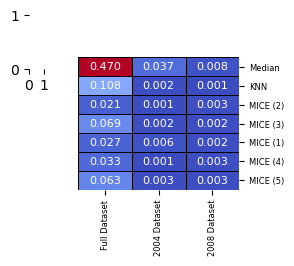

In [8]:
plot.plot_clustermap(
    mse_df.iloc[1:,:].loc[:,["Full Dataset","2004 Dataset","2008 Dataset"]],
    row_cluster=False,
    col_cluster=False,
    vmin=0, vmax=None,
    figsize=(3,3), annot=True, annot_kws={"size": 8}, fmt='.3f',
    yticklabels=["Median","KNN","MICE (2)", "MICE (3)", "MICE (1)", "MICE (4)", "MICE (5)"]
    , cbar=False
)
plt.savefig("figures/imputation_mse.pdf", dpi=200, bbox_inches="tight")

In [53]:
mse_df.iloc[1:,].idxmin(0)

Full Dataset    mice_imputed_2
2004 Dataset    mice_imputed_4
2008 Dataset       knn_imputed
dtype: object

### Table
---

In [97]:
utils.create_imputed_tableone(imp, "tables/supplement/imputed_full_dataset.xlsx", "full_dataset")
utils.create_imputed_tableone(imp, "tables/supplement/imputed_2004_dataset.xlsx", "2004_dataset")
utils.create_imputed_tableone(imp, "tables/supplement/imputed_2008_dataset.xlsx", "2008_dataset")

/Users/sanand/anaconda3/envs/r4/lib/python3.10/site-packages/tableone/tableone.py:370: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  self._groupbylvls = sorted(data.groupby(groupby).groups.keys())  # type: ignore
/Users/sanand/anaconda3/envs/r4/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))
/Users/sanand/anaconda3/envs/r4/lib/python3.10/site-packages/tableone/tableone.py:927: FutureWarning: The provided callable <function mean at 0x108e93be0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_cont = pd.pivot_t